In [1]:
import numpy as np
import matplotlib.pyplot as plt
from geodesic_toolbox import *
import torch
from torch import Tensor
from utils import *

# Oui

<Axes: >

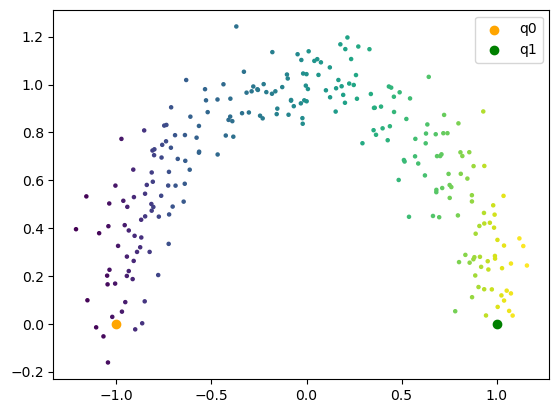

In [26]:
X, t = generate_half_moon_data(n_samples=500, noise=0.1)
idx = torch.randint(0, X.shape[0], (2,))

# X = X[X[:, 0] < -0.2 or X[:, 0] > 0.2]
# idx = torch.logical_or(X[:, 0] < -0.4, X[:, 0] > 0.4)
# idx_ = torch.logical_and(X[:, 0] > -0.2, X[:, 0] < 0.2)
# idx = torch.logical_or(idx, idx_)
# X = X[idx]
# t = t[idx]
# q0 = X[idx[0]].unsqueeze(0)
# q1 = X[idx[1]].unsqueeze(0)
q0 = torch.Tensor([[-1.0, 0.0]]).to(float)
q1 = torch.Tensor([[1.0, 0.0]]).to(float)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=5, c=t)
plot_traj(q0=q0, q1=q1, ax=ax)

In [27]:
base_cometric = IdentityCoMetric()
cometric = CentroidsCometric(
    centroids=X.to(torch.double),
    cometric_centroids=base_cometric(X),
    temperature=0.1,
    # K=256,
)

Computing magnification factor:  46%|████▌     | 36/79 [00:00<00:00, 353.77batch/s]

Computing magnification factor: 100%|██████████| 79/79 [00:00<00:00, 273.31batch/s]


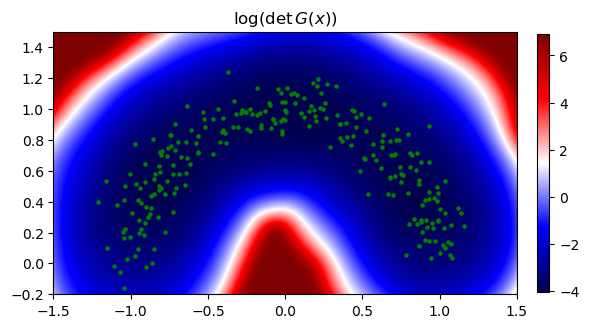

In [28]:
extent = (-1.5, 1.5, -0.2, 1.5)
mf = get_mf_image(cometric, X, bounds=extent)
plt.figure()
img = plt.imshow(
    mf.log(),
    extent=extent,
    origin="lower",
    cmap="seismic",
    interpolation="bilinear",
)
plt.scatter(X[:, 0], X[:, 1], s=5, c="green")
plt.colorbar(img, fraction=0.026, pad=0.04)
plt.title(r"""$\log(\det G(x))$""")
# plt.axis("off")
plt.show()

tensor([[0.0363, 0.0363]], dtype=torch.float64) tensor([[[1., 0.],
         [0., 1.]]], dtype=torch.float64)


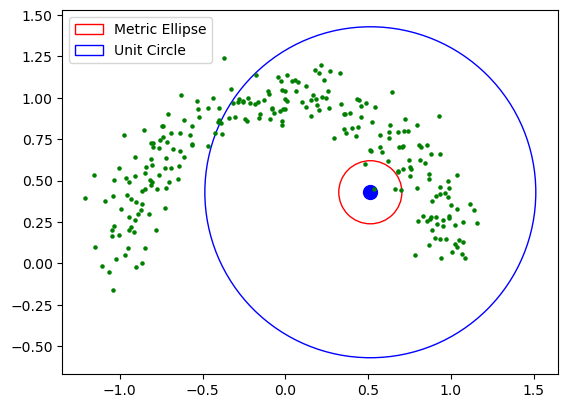

torch.Size([1])

In [59]:
q = torch.randn(1, 2)


class TestCometric(CoMetric):
    def __init__(self, a=2.0, b=1.0):
        super().__init__()
        self.mat = torch.tensor([[a, 0.0], [0.0, b]], dtype=torch.float64)

    def forward(self, q: Tensor) -> Tensor:
        return self.mat


# cometric = TestCometric(a=2.0, b=1.0)
# q = torch.tensor([[-0.0, 1]])
q = torch.randn(1, 2).to(torch.double)
G = cometric.metric_tensor(q)
eigenvalues, eigenvectors = torch.linalg.eigh(G)
print(eigenvalues, eigenvectors)
a, b = eigenvalues[:, 0], eigenvalues[:, 1]
theta = torch.atan2(eigenvectors[:, 1, 0], eigenvectors[:, 0, 0])

from matplotlib.patches import Ellipse, Circle

fig, ax = plt.subplots()
for i, (q_, a_, b_, theta_) in enumerate(zip(q, a, b, theta)):
    ellipse = Ellipse(
        xy=(q_[0].item(), q_[1].item()),
        width=2 * np.sqrt(a_.item()),
        height=2 * np.sqrt(b_.item()),
        angle=np.degrees(theta_.item()),
        edgecolor="red",
        facecolor="none",
        label="Metric Ellipse" if i == 0 else None,
    )
    circle = Circle(
        xy=(q_[0].item(), q_[1].item()),
        radius=1.0,
        edgecolor="blue",
        facecolor="none",
        label="Unit Circle" if i == 0 else None,
    )
    ax.add_patch(ellipse)
    ax.add_patch(circle)

ax.scatter(q[:, 0].numpy(), q[:, 1].numpy(), color="blue", s=100)
ax.scatter(X[:, 0], X[:, 1], s=5, c="green")

ax.set_aspect("equal")
ax.legend()
plt.show()
theta.shape

# Explore centroid cometric

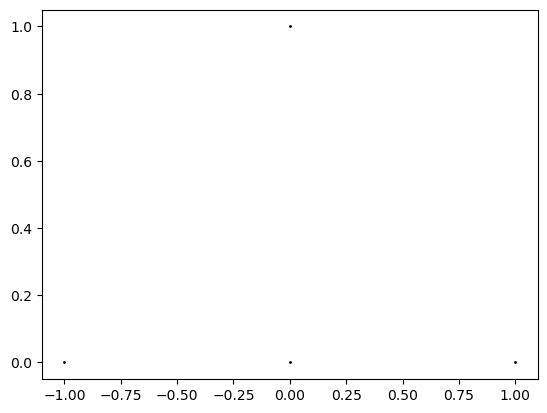

In [2]:
x_all = torch.rand(100, 2).to("cuda")
x_all, t = generate_half_moon_data(n_samples=500, noise=0.1)
x_all = torch.Tensor(
    [
        [0, 0],
        [1, 0],
        [-1, 0],
        [0, 1],
    ]
).to("cuda")
# idx = torch.randint(0, X.shape[0], (2,))
plt.scatter(x_all[:, 0].cpu(), x_all[:, 1].cpu(), s=1, c="black")

In [3]:
class RandomPSD(CoMetric):
    def __init__(self, dim: int, std=1e-3, seed: int = 0):
        super().__init__()
        self.dim = dim
        self.std = std

    def forward(self, q: Tensor) -> Tensor:
        A = torch.randn(q.shape[0], self.dim, self.dim).to(q.device)
        A = A @ A.transpose(-1, -2)  # Make it symmetric positive definite
        A = A / self.std**2  # Scale the values
        return A + self.eye(q) * 1e-3  # Ensure positive definiteness

In [10]:
cometric = CentroidsCometric(
    centroids=x_all,
    # cometric_centroids=RandomPSD(2)(x_all),
    cometric_centroids=IdentityCoMetric()(x_all),
    K=16,
    metric_weight=True,
)
cometric

CentroidsCometric(K=4, temperature=1.000, reg_coef=0.001, metric_weight=True, is_diag=True)

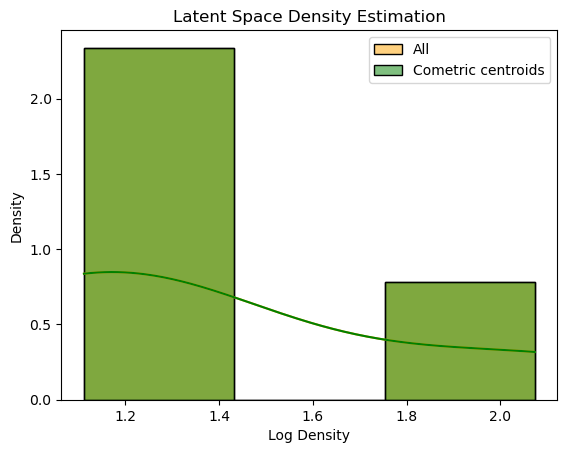

In [11]:
def get_densities(z, cometric, b_size: int = 64):
    densities = []
    for i in range(0, z.shape[0], b_size):
        z_batch = z[i : i + b_size]
        G_inv = cometric(z_batch)  # (B, D, D)|(T, D, D)
        if cometric.is_diag:
            log_det = G_inv.log().sum(dim=-1)  # (B,)
        else:
            log_det = torch.logdet(G_inv)  # (B,)
        densities.append(log_det.cpu())
    densities = torch.cat(densities, dim=0)
    return densities


densities_centroids = get_densities(cometric.centroids, cometric)
densities_all = get_densities(x_all, cometric)
import seaborn as sns

sns.histplot(
    densities_all.numpy(),
    color="orange",
    label="All",
    kde=True,
    alpha=0.5,
    stat="density",
)
sns.histplot(
    densities_centroids.numpy(),
    color="green",
    label="Cometric centroids",
    kde=True,
    alpha=0.5,
    stat="density",
)
plt.legend()
plt.xlabel("Log Density")
plt.ylabel("Density")
plt.title("Latent Space Density Estimation")
plt.show()

In [12]:
def get_ellipsis(q: Tensor, psd_mat: Tensor):
    """Return a patch Ellipsis from a point and a PSD matrix representing the ellipsis

    q : Tensor (2,)
        Center of the ellipsis
    psd_mat : Tensor (2,2) or (2,)
        PSD matrix representing the ellipsis. If (2,), the matrix is assumed to be diagonal.
    """

    x, y = q[0].item(), q[1].item()
    if psd_mat.shape == (2,):
        a, b = psd_mat[0].item(), psd_mat[1].item()
        theta = 0.0
    else:
        eigenvalues, eigenvectors = torch.linalg.eigh(psd_mat)
        a, b = eigenvalues[0].item(), eigenvalues[1].item()
        theta = torch.atan2(eigenvectors[1, 0], eigenvectors[0, 0]).item()
    ellipse = Ellipse(
        xy=(x, y),
        width=2 * np.sqrt(a),
        height=2 * np.sqrt(b),
        angle=np.degrees(theta),
        edgecolor="red",
        facecolor="none",
    )
    return ellipse

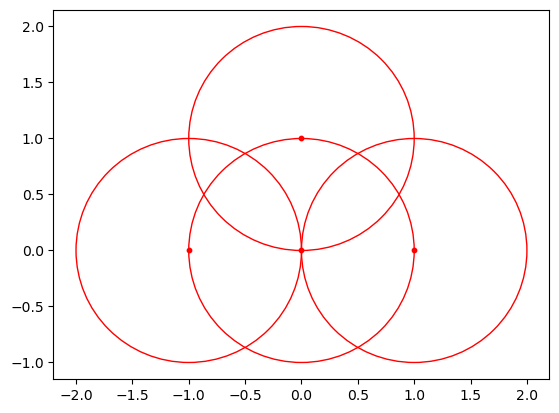

In [13]:
from matplotlib.patches import Ellipse, Circle

fig, ax = plt.subplots()
ax.scatter(x_all[:, 0].cpu(), x_all[:, 1].cpu(), s=1, c="black")
ax.scatter(cometric.centroids[:, 0].cpu(), cometric.centroids[:, 1].cpu(), s=10, c="red")
for i in range(cometric.centroids.shape[0]):
    ellipsis = get_ellipsis(
        cometric.centroids[i],
        cometric.cometric_centroids[i],
    )
    ax.add_patch(ellipsis)

Computing magnification factor: 100%|██████████| 79/79 [00:00<00:00, 947.94batch/s]


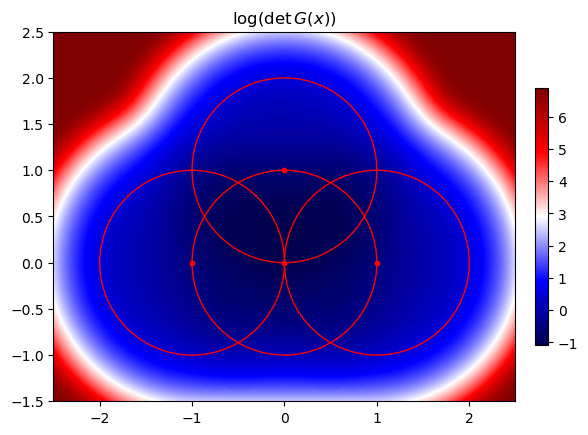

In [14]:
# extent = (0, 1, 0, 1)
# extent = (-5, 1.5, -0.2, 1.5)
extent = (
    x_all[:, 0].min().item() - 1.5,
    x_all[:, 0].max().item() + 1.5,
    x_all[:, 1].min().item() - 1.5,
    x_all[:, 1].max().item() + 1.5,
)
mf = get_mf_image(cometric, x_all, bounds=extent)
fig, ax = plt.subplots()
img = ax.imshow(
    mf.log(),
    extent=extent,
    origin="lower",
    cmap="seismic",
    interpolation="bilinear",
)
ax.scatter(x_all[:, 0].cpu(), x_all[:, 1].cpu(), s=1, c="black")
ax.scatter(cometric.centroids[:, 0].cpu(), cometric.centroids[:, 1].cpu(), s=10, c="red")
for i in range(cometric.centroids.shape[0]):
    ellipsis = get_ellipsis(
        cometric.centroids[i],
        cometric.cometric_centroids[i],
    )
    ax.add_patch(ellipsis)
plt.colorbar(img, fraction=0.026, pad=0.04)
plt.title(r"""$\log(\det G(x))$""")
# plt.axis("off")
plt.show()

In [9]:
cometric.reg_coef.log() * 2

tensor(-13.8155)